# Clustering Compairson algorithms

This notebook has intuite to compare three techniques of clutering: K-means, Robust Sparse K-Means, and Adaptively Sparse K-Means using the [US Highway Rail Road Crossing Accident](https://www.kaggle.com/datasets/yogidsba/us-highway-railgrade-crossing-accident). And use explainable AI with SHAP values to explain the results of the models.

In [1]:
!pip install aquirdturtle_collapsible_headings
!pip install 'python-lsp-server[all]'
!pip install jupyterlab-spellchecker
!pip install jupyterlab-code-formatter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 4.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.8/529.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 8.4.0
    Uninstalling jupyter_client-8.4.0:
      Successfully uninstalled jupyter_client-8.4.0
  Attempting uninstall: notebook
    Found existing installation: notebook 7.0.6
    Uninstalling notebook-7.0.6:
      Successfully uninstalled notebook-7.0.6
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.0.7
    Uninstalling jupyterlab-4.0.7:
      Successfully uninstalled jupyterlab-4.0.7
INFO: pip is looking at multiple versions of flake8 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━

In [1]:
!pip install numpy pandas scikit-learn shap scipy kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yogidsba/us-highway-railgrade-crossing-accident")

print("Path to dataset files:", path)

100%|██████████| 23.6M/23.6M [00:08<00:00, 3.00MB/s]

Extracting files...


Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/yogidsba/us-highway-railgrade-crossing-accident/versions/1


## Implementação dos algoritmos do Robust Sparse K-Means e do Adaptively Sparse K-Means

In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def RSKC(d, ncl, alpha, L1=12, nstart=200, silent=True, scaling=False, correlation=False):
    """
    Python implementation of Robust Sparse K-means Clustering (RSKC)

    Parameters:
    -----------
    d : array-like
        Data matrix (samples x features)
    ncl : int
        Number of clusters
    alpha : float
        Proportion of outliers (between 0 and 1)
    L1 : float or None
        L1 constraint parameter for feature weights. If None, non-sparse version is used
    nstart : int
        Number of random initializations
    silent : bool
        Whether to suppress progress messages
    scaling : bool
        Whether to standardize the data
    correlation : bool
        Whether to apply column-wise standardization

    Returns:
    --------
    dict : Results of the RSKC algorithm
    """
    # Check parameters validity
    if alpha > 1 or alpha < 0:
        raise ValueError("alpha must be between 0 and 1")

    if L1 is not None and L1 < 1:
        raise ValueError(f"L1 value must be greater or equal to 1 or NULL! L1={L1}")

    # Convert dataframe to numpy array if needed
    if isinstance(d, pd.DataFrame):
        d = np.array(d)

    # Ensure ncl is an integer
    r_ncl = round(ncl)
    if ncl != r_ncl:
        ncl = r_ncl

    if ncl <= 1:
        raise ValueError(f"ncl must be positive integer > 1! but ncl={ncl}")

    # Apply scaling if requested
    if scaling:
        d = (d - np.mean(d, axis=0)) / np.std(d, axis=0, ddof=1)

    if correlation:
        # Column-wise standardization (equivalent to R's scale(t(d)))
        d = (d.T - np.mean(d, axis=1)).T
        d = (d.T / np.std(d, axis=1, ddof=1)).T

    # Set sparse mode based on L1
    sparse = False if L1 is None else True

    n = d.shape[0]  # number of samples
    f = d.shape[1]  # number of features
    g = f + 1
    W = np.ones(f)  # weights for non-sparse version
    sumW = f  # sum of weights

    # Number of outliers to identify
    Nout = int(np.floor(n * alpha))

    # Check if data contains missing values
    if np.sum(np.isnan(d)) == 0:
        miss = False

        if sparse:
            Result = RSKC_a1_a2_b(d, L1, ncl, nstart, alpha, n, f, g, Nout, silent)
        else:
            # Non-sparse version
            Result = RSKC_trimkmeans(d, ncl, trim=alpha, runs=nstart, maxit=10000)
    else:
        # Handle missing data
        d[np.isnan(d)] = np.nan
        miss = True

        if sparse:
            Result = RSKC_a1_a2_b_missing(d, L1, ncl, nstart, alpha, n, f, g, Nout, silent)
        else:
            # Non-sparse with missing data
            Result = RSKC_trimkmeans_missing(d=d, ncl=ncl, w=W, trim=alpha, runs=nstart, points=float('inf'), maxit=10000)

    # Process results based on sparse flag
    if sparse:
        # Sparse results processing
        Result['oW'] = np.sort(Result['oW'])
        if Nout == 0:
            # Pure sparse K-means
            Result['oW'] = Result['oE'] = "undefined"
    else:
        # Non-sparse results processing
        Result = modified_result_nonsparse(Result, ncl, f)
        if Nout == 0:
            # Standard K-means
            Result = modified_result_kmean(Result)

    # Clean up unnecessary keys
    keys_to_remove = ['disttom', 'ropt', 'trim', 'scaling', 'centers', 'criterion',
                      'classification', 'means', 'ropt', 'k', 'runs']
    for key in keys_to_remove:
        if key in Result:
            del Result[key]

    # Set feature names if available
    if hasattr(d, 'columns'):
        if 'weights' in Result:
            Result['weights'] = pd.Series(Result['weights'], index=d.columns)

    # Create final result object
    Input = {
        'N': n,
        'p': f,
        'ncl': ncl,
        'L1': L1,
        'nstart': nstart,
        'alpha': alpha,
        'scaling': scaling,
        'correlation': correlation,
        'missing': miss
    }

    # Combine input parameters and results
    r2 = {**Input, **Result}
    r2['type'] = "rskc"  # Similar to class in R

    return r2

def modified_result_nonsparse(Result, ncl, f):
    """
    Process non-sparse clustering results

    Parameters:
    -----------
    Result : dict
        Clustering results dictionary
    ncl : int
        Number of clusters
    f : int
        Number of features

    Returns:
    --------
    dict : Modified results
    """
    Result['centers'] = Result['means']
    Result['oW'] = np.where(Result['classification'] == ncl + 1)[0]
    Result['oE'] = "undefined"
    Result['weights'] = np.ones(f)
    return Result

def modified_result_kmean(Result):
    """
    Process standard K-means results

    Parameters:
    -----------
    Result : dict
        Clustering results dictionary

    Returns:
    --------
    dict : Modified results
    """
    Result['oE'] = Result['oW'] = "undefined"
    Result['labels'] = Result['classification']
    return Result

def RSKC_trimkmeans(d, ncl, trim=0, runs=10, maxit=10000):
    """
    Trimmed K-means clustering

    Parameters:
    -----------
    d : array-like
        Data matrix (samples x features)
    ncl : int
        Number of clusters
    trim : float
        Proportion of outliers (between 0 and 1)
    runs : int
        Number of random initializations
    maxit : int
        Maximum number of iterations

    Returns:
    --------
    dict : Results of trimmed K-means
    """
    n = d.shape[0]
    p = d.shape[1]

    # Number of observations to trim
    n_trim = int(np.floor(n * trim))

    # Initialize best solution
    best_obj = float('inf')
    best_centers = None
    best_labels = None
    best_trimmed = None

    # Run multiple initializations
    for _ in range(runs):
        # Regular K-means initialization
        kmeans = KMeans(n_clusters=ncl, n_init=1, max_iter=maxit).fit(d)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_

        # Trimming step if needed
        if n_trim > 0:
            # Calculate distances to assigned centers
            distances = np.zeros(n)
            for i in range(n):
                distances[i] = np.sum((d[i] - centers[labels[i]])**2)

            # Identify trimmed observations
            trim_indices = np.argsort(distances)[-n_trim:]
            non_trim_indices = np.setdiff1d(np.arange(n), trim_indices)

            # Update cluster centers and objective function
            obj_val = 0
            for c in range(ncl):
                cluster_points = non_trim_indices[labels[non_trim_indices] == c]
                if len(cluster_points) > 0:
                    centers[c] = np.mean(d[cluster_points], axis=0)
                    obj_val += np.sum(np.sum((d[cluster_points] - centers[c])**2))

            # Reassign all points
            distances = cdist(d, centers, 'sqeuclidean')
            labels = np.argmin(distances, axis=1)

            # Create classification with trimmed points as a separate class
            classification = labels.copy()
            classification[trim_indices] = ncl  # Mark trimmed points as outliers
        else:
            # No trimming
            obj_val = kmeans.inertia_
            classification = labels
            trim_indices = []

        # Update best solution if current is better
        if obj_val < best_obj:
            best_obj = obj_val
            best_centers = centers
            best_labels = labels
            best_trimmed = trim_indices
            best_classification = classification

    # Prepare result
    result = {
        'means': best_centers,
        'labels': best_labels,
        'classification': best_classification,
        'criterion': best_obj,
        'trim_indices': best_trimmed
    }

    return result

def RSKC_trimkmeans_missing(d, ncl, w, trim=0, runs=10, points=float('inf'), maxit=10000):
    """
    Trimmed K-means clustering with missing data

    Parameters:
    -----------
    d : array-like
        Data matrix (samples x features) that may contain NaN values
    ncl : int
        Number of clusters
    w : array
        Feature weights
    trim : float
        Proportion of outliers (between 0 and 1)
    runs : int
        Number of random initializations
    points : float
        Maximum number of points to consider (inf for all points)
    maxit : int
        Maximum number of iterations

    Returns:
    --------
    dict : Results of trimmed K-means with missing data handling
    """
    n = d.shape[0]
    p = d.shape[1]

    # Number of observations to trim
    n_trim = int(np.floor(n * trim))

    # Initialize best solution
    best_obj = float('inf')
    best_centers = None
    best_labels = None
    best_trimmed = None

    # Run multiple initializations
    for _ in range(runs):
        # Initialize centers using K-means on complete cases or random selection
        complete_cases = ~np.any(np.isnan(d), axis=1)

        if np.sum(complete_cases) >= ncl:
            # Use complete cases for initialization
            init_data = d[complete_cases]
            kmeans = KMeans(n_clusters=ncl, n_init=1).fit(init_data)
            centers = kmeans.cluster_centers_
        else:
            # Random initialization using feature means
            centers = np.zeros((ncl, p))
            for j in range(p):
                col_mean = np.nanmean(d[:, j])
                for i in range(ncl):
                    centers[i, j] = col_mean + np.random.normal(0, np.nanstd(d[:, j]) / 5)

        # Iterative process for handling missing data
        for iter in range(maxit):
            old_centers = centers.copy()

            # Compute weighted distances with missing data handling
            distances = np.zeros((n, ncl))
            for i in range(n):
                for c in range(ncl):
                    # Use only non-missing features for distance calculation
                    valid_features = ~np.isnan(d[i])
                    if np.sum(valid_features) > 0:
                        distances[i, c] = np.sum(w[valid_features] *
                                                (d[i, valid_features] - centers[c, valid_features])**2)
                    else:
                        distances[i, c] = float('inf')

            # Assign points to nearest center
            labels = np.argmin(distances, axis=1)

            # Identify trimmed observations if needed
            if n_trim > 0:
                min_distances = np.min(distances, axis=1)
                trim_indices = np.argsort(min_distances)[-n_trim:]
                non_trim_indices = np.setdiff1d(np.arange(n), trim_indices)
            else:
                non_trim_indices = np.arange(n)
                trim_indices = []

            # Update cluster centers
            for c in range(ncl):
                cluster_points = non_trim_indices[labels[non_trim_indices] == c]
                if len(cluster_points) > 0:
                    for j in range(p):
                        # Handle missing values by taking mean of available data
                        valid_points = cluster_points[~np.isnan(d[cluster_points, j])]
                        if len(valid_points) > 0:
                            centers[c, j] = np.mean(d[valid_points, j])

            # Check convergence
            if np.allclose(centers, old_centers):
                break

        # Calculate objective function
        obj_val = 0
        for i in range(n):
            if i not in trim_indices:
                c = labels[i]
                valid_features = ~np.isnan(d[i])
                obj_val += np.sum(w[valid_features] * (d[i, valid_features] - centers[c, valid_features])**2)

        # Create classification with trimmed points as a separate class
        classification = labels.copy()
        if n_trim > 0:
            classification[trim_indices] = ncl  # Mark trimmed points as outliers

        # Update best solution if current is better
        if obj_val < best_obj:
            best_obj = obj_val
            best_centers = centers
            best_labels = labels
            best_trimmed = trim_indices
            best_classification = classification

    # Prepare result
    result = {
        'means': best_centers,
        'labels': best_labels,
        'classification': best_classification,
        'criterion': best_obj,
        'trim_indices': best_trimmed
    }

    return result

def RSKC_a1_a2_b(d, L1, ncl, nstart, alpha, n, p, g, Nout, silent):
    """
    Robust Sparse K-means Clustering implementation

    Parameters:
    -----------
    d : array-like
        Data matrix (samples x features)
    L1 : float
        L1 constraint parameter for feature weights
    ncl : int
        Number of clusters
    nstart : int
        Number of random initializations
    alpha : float
        Proportion of outliers
    n : int
        Number of samples
    p : int
        Number of features
    g : int
        Number of features + 1
    Nout : int
        Number of outliers to identify
    silent : bool
        Whether to suppress progress messages

    Returns:
    --------
    dict : Results of RSKC algorithm
    """
    # Initialize best objective and weights
    best_obj = -float('inf')
    best_weights = None
    best_cluster = None
    best_outliers = None
    best_centers = None

    # Start multiple initializations
    for start in range(nstart):
        if not silent and start % 10 == 0:
            print(f"Starting initialization {start + 1} of {nstart}")

        # Step 1: Initialize weights uniformly
        weights = np.ones(p) / np.sqrt(p)

        # Initialize outliers as empty
        outliers = np.array([], dtype=int)

        # Initialize with regular K-means
        kmeans = KMeans(n_clusters=ncl, n_init=1).fit(d)
        cluster_labels = kmeans.labels_
        centers = kmeans.cluster_centers_

        for iter in range(20):  # Maximum iterations for alternating optimization
            # Step 2: Update weights with fixed clusters and outliers
            # Calculate between-cluster sum of squares (BCSS)
            D = np.zeros(p)
            for j in range(p):
                # Calculate feature-specific BCSS
                bcss_j = 0
                for c in range(ncl):
                    cluster_points = np.setdiff1d(np.where(cluster_labels == c)[0], outliers)
                    if len(cluster_points) > 0:
                        bcss_j += len(cluster_points) * (np.mean(d[cluster_points, j]) - np.mean(d[:, j]))**2
                D[j] = bcss_j

            # Soft-thresholding for weights
            sorted_idx = np.argsort(D)[::-1]  # Descending order
            cumsum_D = np.cumsum(np.sqrt(D[sorted_idx]))

            # Find threshold that satisfies L1 constraint
            s = 0
            while s < p and cumsum_D[s] < L1:
                s += 1
            s = max(1, s)

            # Calculate threshold
            delta = (cumsum_D[s-1] - L1) / s if s > 0 else 0

            # Update weights using soft-thresholding
            new_weights = np.zeros(p)
            for j in range(p):
                if np.sqrt(D[j]) > delta:
                    new_weights[j] = (np.sqrt(D[j]) - delta) / np.sqrt(np.sum((np.sqrt(D) - delta)**2 * (np.sqrt(D) > delta)))

            # Step 3: Update clusters with fixed weights and outliers
            # Use weighted K-means
            weighted_d = d * new_weights

            # Exclude outliers
            if len(outliers) > 0:
                valid_indices = np.setdiff1d(np.arange(n), outliers)
                kmeans = KMeans(n_clusters=ncl, n_init=1).fit(weighted_d[valid_indices])

                # Update centers and labels
                centers = kmeans.cluster_centers_
                new_labels = np.zeros(n, dtype=int)

                # Assign labels to non-outliers
                new_labels[valid_indices] = kmeans.labels_

                # Assign closest cluster to outliers (they remain outliers)
                for i in outliers:
                    distances = np.array([np.sum(new_weights * (d[i] - centers[c])**2) for c in range(ncl)])
                    new_labels[i] = np.argmin(distances)
            else:
                kmeans = KMeans(n_clusters=ncl, n_init=1).fit(weighted_d)
                centers = kmeans.cluster_centers_
                new_labels = kmeans.labels_

            # Step 4: Update outliers with fixed clusters and weights
            if Nout > 0:
                # Calculate distances to assigned centers
                distances = np.zeros(n)
                for i in range(n):
                    distances[i] = np.sum(new_weights * (d[i] - centers[new_labels[i]])**2)

                # Identify outliers as points with largest distances
                outliers = np.argsort(distances)[-Nout:]

            # Check convergence
            if np.array_equal(new_labels, cluster_labels) and np.allclose(new_weights, weights):
                break

            cluster_labels = new_labels.copy()
            weights = new_weights.copy()

        # Calculate objective function
        obj_val = 0
        for c in range(ncl):
            cluster_points = np.setdiff1d(np.where(cluster_labels == c)[0], outliers)
            if len(cluster_points) > 0:
                for j in range(p):
                    obj_val += weights[j] * len(cluster_points) * (np.mean(d[cluster_points, j]) - np.mean(d[:, j]))**2

        # Update best solution if current is better
        if obj_val > best_obj:
            best_obj = obj_val
            best_weights = weights
            best_cluster = cluster_labels
            best_outliers = outliers
            best_centers = centers

    # Create classification with outliers marked
    classification = best_cluster.copy()
    if Nout > 0:
        classification[best_outliers] = ncl  # Mark outliers as a separate class

    # Prepare result
    result = {
        'weights': best_weights,
        'labels': best_cluster,
        'classification': classification,
        'oW': best_outliers,  # Outlier indices
        'oE': obj_val,  # Objective value
        'means': best_centers  # Cluster centers
    }

    return result

def RSKC_a1_a2_b_missing(d, L1, ncl, nstart, alpha, n, p, g, Nout, silent):
    """
    Robust Sparse K-means Clustering implementation with missing data handling

    Parameters:
    -----------
    d : array-like
        Data matrix (samples x features) that may contain NaN values
    L1 : float
        L1 constraint parameter for feature weights
    ncl : int
        Number of clusters
    nstart : int
        Number of random initializations
    alpha : float
        Proportion of outliers
    n : int
        Number of samples
    p : int
        Number of features
    g : int
        Number of features + 1
    Nout : int
        Number of outliers to identify
    silent : bool
        Whether to suppress progress messages

    Returns:
    --------
    dict : Results of RSKC algorithm with missing data handling
    """
    # Initialize best objective and weights
    best_obj = -float('inf')
    best_weights = None
    best_cluster = None
    best_outliers = None
    best_centers = None

    # Start multiple initializations
    for start in range(nstart):
        if not silent and start % 10 == 0:
            print(f"Starting initialization {start + 1} of {nstart}")

        # Step 1: Initialize weights uniformly
        weights = np.ones(p) / np.sqrt(p)

        # Initialize outliers as empty
        outliers = np.array([], dtype=int)

        # Initialize with K-means on complete cases or using feature-wise means
        complete_cases = ~np.any(np.isnan(d), axis=1)
        if np.sum(complete_cases) >= ncl:
            # Use complete cases for initialization
            init_data = d[complete_cases]
            kmeans = KMeans(n_clusters=ncl, n_init=1).fit(init_data)
            centers = kmeans.cluster_centers_

            # Assign all points to clusters
            cluster_labels = np.zeros(n, dtype=int)
            for i in range(n):
                distances = np.zeros(ncl)
                for c in range(ncl):
                    # Use only non-missing features for distance calculation
                    valid_features = ~np.isnan(d[i])
                    if np.sum(valid_features) > 0:
                        distances[c] = np.sum((d[i, valid_features] - centers[c, valid_features])**2)
                    else:
                        distances[c] = float('inf')
                cluster_labels[i] = np.argmin(distances)
        else:
            # Random initialization using feature means
            centers = np.zeros((ncl, p))
            for j in range(p):
                col_mean = np.nanmean(d[:, j])
                col_std = np.nanstd(d[:, j])
                for c in range(ncl):
                    centers[c, j] = col_mean + np.random.normal(0, col_std / 5)

            # Assign points to clusters
            cluster_labels = np.zeros(n, dtype=int)
            for i in range(n):
                distances = np.zeros(ncl)
                for c in range(ncl):
                    valid_features = ~np.isnan(d[i])
                    if np.sum(valid_features) > 0:
                        distances[c] = np.sum((d[i, valid_features] - centers[c, valid_features])**2)
                    else:
                        distances[c] = float('inf')
                cluster_labels[i] = np.argmin(distances)

        for iter in range(20):  # Maximum iterations for alternating optimization
            # Step 2: Update weights with fixed clusters and outliers
            # Calculate between-cluster sum of squares (BCSS) with missing data handling
            D = np.zeros(p)
            for j in range(p):
                # Skip if all values for feature j are missing
                if np.all(np.isnan(d[:, j])):
                    continue

                # Calculate feature-specific BCSS with missing data handling
                bcss_j = 0
                valid_data_j = ~np.isnan(d[:, j])
                overall_mean_j = np.nanmean(d[:, j])

                for c in range(ncl):
                    # Get cluster points excluding outliers
                    cluster_points = np.setdiff1d(np.where(cluster_labels == c)[0], outliers)
                    # Filter for valid data in this feature and cluster
                    valid_cluster_points = np.intersect1d(cluster_points, np.where(valid_data_j)[0])

                    if len(valid_cluster_points) > 0:
                        cluster_mean_j = np.mean(d[valid_cluster_points, j])
                        bcss_j += len(valid_cluster_points) * (cluster_mean_j - overall_mean_j)**2

                D[j] = bcss_j

            # Soft-thresholding for weights
            sorted_idx = np.argsort(D)[::-1]  # Descending order
            cumsum_D = np.cumsum(np.sqrt(D[sorted_idx]))

            # Find threshold that satisfies L1 constraint
            s = 0
            while s < p and cumsum_D[s] < L1:
                s += 1
            s = max(1, s)

            # Calculate threshold
            delta = (cumsum_D[s-1] - L1) / s if s > 0 else 0

            # Update weights using soft-thresholding
            new_weights = np.zeros(p)
            for j in range(p):
                if np.sqrt(D[j]) > delta:
                    new_weights[j] = (np.sqrt(D[j]) - delta) / np.sqrt(np.sum((np.sqrt(D) - delta)**2 * (np.sqrt(D) > delta)))

            # Step 3: Update clusters with fixed weights and outliers
            # Create new centers based on weighted means with missing data handling
            new_centers = np.zeros((ncl, p))
            for c in range(ncl):
                cluster_points = np.setdiff1d(np.where(cluster_labels == c)[0], outliers)
                for j in range(p):
                    # Get valid data points for this feature in this cluster
                    valid_cluster_points = cluster_points[~np.isnan(d[cluster_points, j])]
                    if len(valid_cluster_points) > 0:
                        new_centers[c, j] = np.mean(d[valid_cluster_points, j])
                    else:
                        # Use overall mean if no valid points in cluster
                        new_centers[c, j] = np.nanmean(d[:, j])

            # Assign points to clusters using weighted distances
            new_labels = np.zeros(n, dtype=int)
            for i in range(n):
                if i in outliers:
                    # Keep outliers in their current cluster
                    new_labels[i] = cluster_labels[i]
                    continue

                distances = np.zeros(ncl)
                for c in range(ncl):
                    # Use only non-missing features for distance calculation
                    valid_features = ~np.isnan(d[i])
                    if np.sum(valid_features) > 0:
                        distances[c] = np.sum(new_weights[valid_features] *
                                            (d[i, valid_features] - new_centers[c, valid_features])**2)
                    else:
                        distances[c] = float('inf')
                new_labels[i] = np.argmin(distances)

            # Step 4: Update outliers with fixed clusters and weights
            if Nout > 0:
                # Calculate distances to assigned centers with missing data handling
                distances = np.zeros(n)
                for i in range(n):
                    valid_features = ~np.isnan(d[i])
                    if np.sum(valid_features) > 0:
                        distances[i] = np.sum(new_weights[valid_features] *
                                           (d[i, valid_features] - new_centers[new_labels[i], valid_features])**2)
                    else:
                        distances[i] = float('inf')

                # Identify outliers as points with largest distances
                outliers = np.argsort(distances)[-Nout:]

            # Check convergence
            if np.array_equal(new_labels, cluster_labels) and np.allclose(new_weights, weights):
                break

            cluster_labels = new_labels.copy()
            weights = new_weights.copy()
            centers = new_centers.copy()

        # Calculate objective function with missing data handling
        obj_val = 0
        for c in range(ncl):
            cluster_points = np.setdiff1d(np.where(cluster_labels == c)[0], outliers)
            if len(cluster_points) > 0:
                for j in range(p):
                    # Skip missing values
                    valid_cluster_points = cluster_points[~np.isnan(d[cluster_points, j])]
                    valid_data_j = ~np.isnan(d[:, j])

                    if len(valid_cluster_points) > 0 and np.sum(valid_data_j) > 0:
                        cluster_mean_j = np.mean(d[valid_cluster_points, j])
                        overall_mean_j = np.nanmean(d[:, j])
                        obj_val += weights[j] * len(valid_cluster_points) * (cluster_mean_j - overall_mean_j)**2

        # Update best solution if current is better
        if obj_val > best_obj:
            best_obj = obj_val
            best_weights = weights
            best_cluster = cluster_labels
            best_outliers = outliers
            best_centers = centers

    # Create classification with outliers marked
    classification = best_cluster.copy()
    if Nout > 0:
        classification[best_outliers] = ncl  # Mark outliers as a separate class

    # Prepare result
    result = {
        'weights': best_weights,
        'labels': best_cluster,
        'classification': classification,
        'oW': best_outliers,  # Outlier indices
        'oE': obj_val,  # Objective value
        'means': best_centers  # Cluster centers
    }

    return result

def class_trimk(d, mu, trimC, ncl, Nout):
    """
    Classify observations with trimming

    Parameters:
    -----------
    d : array-like
        Data matrix (samples x features)
    mu : array-like
        Cluster centers
    trimC : array
        Current classification with trimmed observations
    ncl : int
        Number of clusters
    Nout : int
        Number of outliers to identify

    Returns:
    --------
    array : Updated classification
    """
    n = d.shape[0]

    # Calculate distances to all centers
    distances = cdist(d, mu, 'sqeuclidean')

    # Get initial labels based on minimum distance
    labels = np.argmin(distances, axis=1)

    # Identify outliers if needed
    if Nout > 0:
        # Get minimum distance for each point
        min_distances = np.min(distances, axis=1)

        # Identify Nout points with largest distances as outliers
        outlier_indices = np.argsort(min_distances)[-Nout:]

        # Mark outliers in the classification
        labels_with_outliers = labels.copy()
        labels_with_outliers[outlier_indices] = ncl  # ncl is the outlier class

        return labels_with_outliers
    else:
        return labels

def class_trimk_missing(d, mu, trimC, ncl, Nout, w, sumW):
    """
    Classify observations with trimming and missing data handling

    Parameters:
    -----------
    d : array-like
        Data matrix (samples x features) that may contain NaN values
    mu : array-like
        Cluster centers
    trimC : array
        Current classification with trimmed observations
    ncl : int
        Number of clusters
    Nout : int
        Number of outliers to identify
    w : array
        Feature weights
    sumW : float
        Sum of weights

    Returns:
    --------
    array : Updated classification with handling of missing data
    """
    n = d.shape[0]
    p = d.shape[1]

    # Calculate weighted distances with missing data handling
    distances = np.zeros((n, ncl))
    for i in range(n):
        for c in range(ncl):
            # Use only non-missing features for distance calculation
            valid_features = ~np.isnan(d[i])
            if np.sum(valid_features) > 0:
                distances[i, c] = np.sum(w[valid_features] * (d[i, valid_features] - mu[c, valid_features])**2)
            else:
                distances[i, c] = float('inf')

    # Get initial labels based on minimum distance
    labels = np.argmin(distances, axis=1)

    # Identify outliers if needed
    if Nout > 0:
        # Get minimum distance for each point
        min_distances = np.min(distances, axis=1)

        # Identify Nout points with largest distances as outliers
        outlier_indices = np.argsort(min_distances)[-Nout:]

        # Mark outliers in the classification
        labels_with_outliers = labels.copy()
        labels_with_outliers[outlier_indices] = ncl  # ncl is the outlier class

        return labels_with_outliers
    else:
        return labels

# Additional utility functions that might be needed

def weighted_kmeans(data, nclusters, weights, max_iter=100):
    """
    Weighted K-means clustering

    Parameters:
    -----------
    data : array-like
        Data matrix (samples x features)
    nclusters : int
        Number of clusters
    weights : array
        Feature weights
    max_iter : int
        Maximum number of iterations

    Returns:
    --------
    tuple : (centers, labels)
    """
    n, p = data.shape

    # Initialize centers using standard K-means
    kmeans = KMeans(n_clusters=nclusters, n_init=1).fit(data)
    centers = kmeans.cluster_centers_

    # Weighted K-means iterations
    for _ in range(max_iter):
        old_centers = centers.copy()

        # Calculate weighted distances
        weighted_data = data * np.sqrt(weights)
        weighted_centers = centers * np.sqrt(weights)

        # Assign points to nearest center
        distances = cdist(weighted_data, weighted_centers, 'sqeuclidean')
        labels = np.argmin(distances, axis=1)

        # Update centers
        for c in range(nclusters):
            if np.sum(labels == c) > 0:
                centers[c] = np.mean(data[labels == c], axis=0)

        # Check convergence
        if np.allclose(centers, old_centers):
            break

    return centers, labels

def weighted_kmeans_missing(data, nclusters, weights, max_iter=100):
    """
    Weighted K-means clustering with missing data handling

    Parameters:
    -----------
    data : array-like
        Data matrix (samples x features) that may contain NaN values
    nclusters : int
        Number of clusters
    weights : array
        Feature weights
    max_iter : int
        Maximum number of iterations

    Returns:
    --------
    tuple : (centers, labels)
    """
    n, p = data.shape

    # Initialize centers using data means
    centers = np.zeros((nclusters, p))
    for j in range(p):
        col_mean = np.nanmean(data[:, j])
        col_std = np.nanstd(data[:, j])
        centers[:, j] = np.random.normal(col_mean, col_std / 5, size=nclusters)

    # Weighted K-means iterations with missing data handling
    labels = np.zeros(n, dtype=int)
    for _ in range(max_iter):
        old_centers = centers.copy()

        # Assign points to nearest center using only available features
        for i in range(n):
            min_dist = float('inf')
            best_cluster = 0

            for c in range(nclusters):
                # Use only non-missing features for distance calculation
                valid_features = ~np.isnan(data[i])
                if np.sum(valid_features) > 0:
                    dist = np.sum(weights[valid_features] *
                                 (data[i, valid_features] - centers[c, valid_features])**2)
                    if dist < min_dist:
                        min_dist = dist
                        best_cluster = c

            labels[i] = best_cluster

        # Update centers using only available data
        for c in range(nclusters):
            cluster_points = np.where(labels == c)[0]
            if len(cluster_points) > 0:
                for j in range(p):
                    # Get valid data points for this feature in this cluster
                    valid_points = cluster_points[~np.isnan(data[cluster_points, j])]
                    if len(valid_points) > 0:
                        centers[c, j] = np.mean(data[valid_points, j])

        # Check convergence
        if np.allclose(centers, old_centers, equal_nan=True):
            break

    return centers, labels

In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from scipy import linalg

# Equivalent to library imports in R
# We would need these packages' functionality implemented in Python
# Would need to import data-generator.py and gap-alternative.py equivalents
# from data_generator import *
# from gap_alternative import *

# Euclidean distance function
def eudist(x, y):
    """Calculate Euclidean distance between two vectors"""
    return np.sqrt(np.sum((x - y) ** 2))

# Thresholding functions
def soft_threshold(x, c):
    """Soft thresholding function"""
    return np.sign(x) * np.maximum(np.abs(x) - c, 0)

def scad_threshold(entry, lambda_val, a=3.7):
    """SCAD thresholding function"""
    result = entry.copy()

    # Create masks for the different conditions
    e1 = np.abs(entry) <= 2 * lambda_val
    e2 = (np.abs(entry) > 2 * lambda_val) & (np.abs(entry) <= a * lambda_val)

    # Apply the appropriate transformation for each case
    result[e1] = np.where(
        np.abs(entry[e1]) - lambda_val > 0,
        np.sign(entry[e1]) * (np.abs(entry[e1]) - lambda_val),
        0
    )

    result[e2] = ((a - 1) * entry[e2] - np.sign(entry[e2]) * a * lambda_val) / (a - 2)

    return result

def theta_ipod_kmean_involve_lasso(dataset, lambda_val, k, w):
    """Function for Outlier-Robust K-Means (OKM)"""
    dataset = np.asarray(dataset)
    w = np.asarray(w)

    # Calculate total mean
    total_mean = np.mean(dataset, axis=0)

    # Calculate distances from total mean
    all_dis = np.array([eudist(dataset[i, :], total_mean) for i in range(dataset.shape[0])])

    # Choose the furthest 20% points
    a = int(dataset.shape[0] * 0.2)
    most_far_dis = np.sort(all_dis)[::-1][:a]
    most_far_pos = np.where(np.isin(all_dis, most_far_dis))[0]

    # Initialize E matrices
    E_ini = np.zeros((dataset.shape[0], dataset.shape[1]))
    E_n = np.zeros((dataset.shape[0], dataset.shape[1]))

    # Set values for furthest points
    E_ini[most_far_pos, :] = dataset[most_far_pos, :]

    E = E_ini

    # Helper functions for SCAD
    def new_E_s(x, m, lambda_val):
        """Soft thresholding of E"""
        z_n = np.sqrt(np.sum((x - m) ** 2))
        if z_n == 0:
            return np.zeros_like(x)
        return (x - m) * max(0, 1 - (z_n ** -1) * lambda_val)

    def new_E(x, m, lambda_val, a=3.7):
        """SCAD thresholding of E"""
        z_n = np.sqrt(np.sum((x - m) ** 2))
        if z_n <= 2 * lambda_val:
            return new_E_s(x, m, lambda_val)
        elif 2 * lambda_val < z_n and z_n <= a * lambda_val:
            return (a - 1) / (a - 2) * new_E_s(x, m, (a * lambda_val) / (a - 1))
        else:
            return x - m

    # Initial parameters
    kmean_dataset = dataset - E
    kmean_dataset = kmean_dataset * w
    kmeans_res = KMeans(n_clusters=k, n_init=10).fit(kmean_dataset)
    mu_new = kmeans_res.cluster_centers_
    mu_old = mu_new.copy()
    iter_count = 0

    # Iteration part
    while True:
        cluster_number = np.sort(np.unique(kmeans_res.labels_))
        G_res = kmeans_res.labels_
        G_conbin_number = {}  # Dictionary instead of list in R

        for i in cluster_number:
            G_conbin_number[i] = np.where(G_res == i)[0]

        for i in range(len(G_conbin_number)):
            for j in G_conbin_number[i]:
                E_n[j, :] = new_E(dataset * w[j], mu_new[i], lambda_val=lambda_val)

        kmean_dataset = dataset * w - E_n

        kmeans_res = KMeans(n_clusters=k, n_init=10).fit(kmean_dataset)
        cluster_res_final = kmeans_res.labels_
        mu_new = kmeans_res.cluster_centers_

        if eudist(mu_new.flatten(), mu_old.flatten()) < 0.001 or iter_count == 100:
            break

        mu_old = mu_new.copy()
        E = E_n.copy()
        iter_count += 1

    # Judge which points are outliers
    E_2 = np.diag(E @ E.T)
    judge_outliner_idx = np.where(E_2 != 0)[0]

    # Return results
    return {
        'okm_iter': iter_count,
        'E': E,
        'k': k,
        'mu': mu_old,
        'outlier_idx': judge_outliner_idx,
        'cluster_res_final': cluster_res_final
    }

def find_a(w, E_res, k, c, dataset, cl_rest_a):
    """Variable selection function"""
    w = np.asarray(w)
    E_res = np.asarray(E_res)
    dataset = np.asarray(dataset)
    cl_rest_a = np.asarray(cl_rest_a)

    # Replace zeros with ones in the divisor to avoid division by zero
    tata = np.where(w == 0, 1, w)

    E_return = E_res / tata

    new_dataset = dataset - E_return

    # Combine dataset with cluster assignments
    data_with_predict = np.column_stack((new_dataset, cl_rest_a))
    predict_cluster_category = np.sort(np.unique(data_with_predict[:, -1]))

    # All mean and differences
    all_mean = np.mean(data_with_predict[:, :-1], axis=0)
    all_distence = (data_with_predict[:, :-1] - all_mean) ** 2

    # Each group difference
    each_dim_matrix = np.zeros((k, dataset.shape[1]))

    for z in range(len(predict_cluster_category)):
        cluster_id = predict_cluster_category[z]
        group_individual_idx = np.where(data_with_predict[:, -1] == cluster_id)[0]
        each_group = data_with_predict[group_individual_idx, :-1]

        dim_dis_e = np.zeros(each_group.shape[1])
        for p in range(each_group.shape[1]):
            distance_squ_all = np.zeros((len(each_group[:, p]), len(each_group[:, p])))
            for i in range(len(each_group[:, p])):
                for j in range(len(each_group[:, p])):
                    distance_squ_all[i, j] = (each_group[i, p] - each_group[j, p]) ** 2

            dim_dis_e[p] = np.sum(np.mean(distance_squ_all, axis=1)) / 2

        each_dim_matrix[z, :] = dim_dis_e

    # Calculate a_j
    a_j = np.sum(all_distence, axis=0) - np.sum(each_dim_matrix, axis=0)

    # Apply thresholding
    new_a_j = scad_threshold(a_j, c, 3.7)

    # Calculate new weights
    if np.linalg.norm(new_a_j, 2) == 0:
        w = np.zeros_like(new_a_j)
    else:
        w = new_a_j / np.linalg.norm(new_a_j, 2)

    return w

def RSKOD(k, c, lambda_val, dataset, w):
    """Main RSKOD algorithm function"""
    w_path = None
    iter_1 = 0
    j_w_ser = []

    while True:
        print("==s", end="")
        test_res = theta_ipod_kmean_involve_lasso(dataset=dataset, lambda_val=lambda_val, k=k, w=w)
        w_a = find_a(w=w, E_res=test_res['E'], k=k, c=c, dataset=dataset, cl_rest_a=test_res['cluster_res_final'])

        w_diff = np.sum(np.abs(w_a - w)) / np.sum(np.abs(w)) if np.sum(np.abs(w)) != 0 else 0
        print(w_diff)

        if w_diff < 0.01 or iter_1 == 50:
            break

        w = w_a.copy()
        j_w_ser.append(w_diff)

        if w_path is None:
            w_path = w.reshape(1, -1)
        else:
            w_path = np.vstack((w, w_path))

        iter_1 += 1

    w_f = w_path[0, :] if w_path is not None else w

    return {
        'w_path': w_path,
        'okm_it': test_res['okm_iter'],
        't_iter': iter_1,
        'w_f': w_f,
        'spare_okm_cluster': test_res['cluster_res_final'],
        'spare_okm_E': test_res['E'],
        'spare_okm_outlier_idx': test_res['outlier_idx']
    }

## Pré Processamento dos Dados


In [6]:
import pandas as pd
# dataset = pd.read_csv('/root/.cache/kagglehub/datasets/yogidsba/us-highway-railgrade-crossing-accident/versions/1/Highway-Rail_Grade_Crossing_Accident_Data.csv', low_memory=False, sep=',')
dataset = pd.read_csv('datasets/Highway-Rail_Grade_Crossing_Accident_Data.csv', low_memory=False, sep=',')

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239487 entries, 0 to 239486
Columns: 141 entries, Railroad Code to Report Key
dtypes: float64(50), int64(12), object(79)
memory usage: 257.6+ MB


In [8]:
dataset.columns.to_list()

['Railroad Code',
 'Railroad Name',
 'Report Year',
 'Incident Number',
 'Incident Year',
 'Incident Month',
 'Other Railroad Code',
 'Other Railroad Name',
 'Other Incident Number',
 'Other Incident Year',
 'Other Incident Month',
 'Maintenance Incident Railroad Code',
 'Maintenance Railroad Name',
 'Maintainance Incident Number',
 'Maintenance Incident Year',
 'Maintenance Incident Month',
 'Grade Crossing ID',
 'Date',
 'Time',
 'Month',
 'Day',
 'Hour',
 'Minute',
 'AM/PM',
 'Nearest Station',
 'Division',
 'Subdivision',
 'County Code',
 'County Name',
 'State Code',
 'State Name',
 'City Name',
 'Highway Name',
 'Public/Private Code',
 'Public/Private',
 'Highway User Code',
 'Highway User',
 'Estimated Vehicle Speed',
 'Vehicle Direction Code',
 'Vehicle Direction',
 'Highway User Position Code',
 'Highway User Position',
 'Equipment Involved Code',
 'Equipment Involved',
 'Railroad Car Unit Position',
 'Equipment Struck Code',
 'Equipment Struck',
 'Hazmat Involvement Code',
 '

In [9]:
dataset.head()

,Railroad Code,Railroad Name,Report Year,Incident Number,Incident Year,Incident Month,Other Railroad Code,Other Railroad Name,Other Incident Number,Other Incident Year,...,Total Killed Form 57,Total Injured Form 57,Railroad Type,Joint Code,Total Killed Form 55A,Total Injured Form 55A,District,Whistle Ban Code,Whistle Ban,Report Key
0,BNSF,BNSF Railway Company,2009,CA0109200,9,1,NaN,NaN,NaN,NaN,...,0,1,1L,1,0,1,7.0,2.0,No,BNSFCA0109200200901
1,BNSF,BNSF Railway Company,2009,CA0109201,9,1,NaN,NaN,NaN,NaN,...,1,6,1L,1,1,6,7.0,2.0,No,BNSFCA0109201200901
2,NS,Norfolk Southern Railway Company,2020,139633,20,11,NaN,NaN,NaN,NaN,...,0,0,1,1,0,0,3.0,NaN,NaN,NS139633202011
3,BNSF,BNSF Railway Company,2008,CA0208200,8,2,NaN,NaN,NaN,NaN,...,0,2,1L,1,0,2,7.0,2.0,No,BNSFCA0208200200802
4,BNSF,BNSF Railway Company,2008,CA0208201,8,2,NaN,NaN,NaN,NaN,...,0,1,1L,1,0,1,7.0,2.0,No,BNSFCA0208201200802


In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Seu código existente
features = [
    # --- Resultados Diretos (Vítimas e Custo) ---
    'Crossing Users Killed For Reporting Railroad',
    'Crossing Users Injured For Reporting Railroad',
    'Employees Killed For Reporting Railroad',
    'Employees Injured For Reporting Railroad',
    'Passengers Killed For Reporting Railroad',
    'Passengers Injured For Reporting Railroad',
    'Total Killed Form 57',
    'Total Injured Form 57',
    'Total Killed Form 55A',
    'Total Injured Form 55A',
    'Vehicle Damage Cost',

    # --- Fatores Contribuintes e Contexto ---
    # Comportamento e Situação do Usuário da Via
    'Highway User Position Code',
    'Highway User Action Code',
    'View Obstruction Code',

    # Infraestrutura e Sinalização da Passagem
    'Crossing Warning Expanded Code 1',
    'Crossing Warning Expanded Code 2',
    'Crossing Warning Expanded Code 3',
    'Crossing Warning Expanded Code 4',
    # 'Crossing Warning Expanded Code 5', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 6', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 7', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 8', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 9', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 10', - Poucas Linhas com dados Non-Null
    # 'Crossing Warning Expanded Code 11', - Poucas Linhas com dados Non-Null
    'Crossing Warning Expanded Code 12',
    'Signaled Crossing Warning Code',
    'Crossing Warning Explanation Code',
    'Warning Connected To Signal',
    'Crossing Illuminated',

    # Condições Ambientais
    'Roadway Condition Code',
    'Weather Condition Code',
    'Visibility Code',

    # Características do Trem e Carga
    'Hazmat Involvement Code',
    'Hazmat Released by Code',
    'Train Speed',
    'Equipment Type Code'
]

X = dataset[features]

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239487 entries, 0 to 239486
Data columns (total 30 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Crossing Users Killed For Reporting Railroad   237239 non-null  float64
 1   Crossing Users Injured For Reporting Railroad  237643 non-null  float64
 2   Employees Killed For Reporting Railroad        236971 non-null  float64
 3   Employees Injured For Reporting Railroad       237044 non-null  float64
 4   Passengers Killed For Reporting Railroad       233401 non-null  float64
 5   Passengers Injured For Reporting Railroad      233343 non-null  float64
 6   Total Killed Form 57                           239487 non-null  int64  
 7   Total Injured Form 57                          239487 non-null  int64  
 8   Total Killed Form 55A                          239487 non-null  int64  
 9   Total Injured Form 55A               

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que seu DataFrame 'dataset' já esteja carregado
# e a variável 'features' contenha a lista das colunas numéricas originais

# 1. Identificar as colunas categóricas para one-hot encoding
categorical_cols = [
  'Signaled Crossing Warning Code',
  'Crossing Warning Explanation Code',
  'Warning Connected To Signal',
  'Crossing Illuminated',
  'Roadway Condition Code',
  'Equipment Type Code'
]

# 2. Aplicar o One-Hot Encoding
dataset_encoded = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols)

# 3. Identificar as novas features (incluindo as numéricas originais e as codificadas)
# Vamos assumir que as colunas numéricas originais estavam em uma lista chamada 'features' antes do encoding.
# Agora, precisamos criar uma nova lista de features para o RSKC, que incluirá as colunas numéricas originais
# e as novas colunas criadas pelo one-hot encoding.

# Para fazer isso, podemos pegar todas as colunas do dataset_encoded que não são as colunas originais categóricas
# e também não são as colunas que adicionamos depois ('cluster' e 'is_outlier', se já existirem).
features_encoded = [col for col in dataset_encoded.columns if col not in categorical_cols and col not in ['cluster', 'is_outlier']]
numerical_features_encoded = dataset_encoded[features_encoded].select_dtypes(include=np.number).columns.tolist()

# 4. Aplicar o StandardScaler nas features codificadas
X = dataset_encoded[numerical_features_encoded]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
X.head()

,Crossing Users Killed For Reporting Railroad,Crossing Users Injured For Reporting Railroad,Employees Killed For Reporting Railroad,Employees Injured For Reporting Railroad,Passengers Killed For Reporting Railroad,Passengers Injured For Reporting Railroad,Total Killed Form 57,Total Injured Form 57,Total Killed Form 55A,Total Injured Form 55A,...,Crossing Warning Expanded Code 1,Crossing Warning Expanded Code 2,Crossing Warning Expanded Code 3,Crossing Warning Expanded Code 4,Crossing Warning Expanded Code 12,Weather Condition Code,Visibility Code,Hazmat Involvement Code,Hazmat Released by Code,Train Speed
0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,1,...,1.0,NaN,NaN,NaN,2.0,4.0,2.0,4.0,4.0,55.0
1,1.0,6.0,0.0,0.0,0.0,0.0,1,6,1,6,...,1.0,NaN,NaN,NaN,3.0,1.0,4.0,2.0,4.0,59.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,2.0,3.0,NaN,NaN,6.0,1.0,3.0,4.0,4.0,5.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0,2,0,2,...,1.0,NaN,NaN,NaN,2.0,4.0,2.0,4.0,4.0,31.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,1,...,1.0,NaN,NaN,NaN,3.0,1.0,2.0,4.0,4.0,70.0


## Robust Sparse K-Means
All the manipulation and executions to RSKC

### Applying RSKC

In [ ]:
# Aplicando o RSKC
# Defina os parâmetros
n_clusters = 21       # Número de clusters
alpha = 0.1          # Proporção de outliers (10%)
L1 = 5               # Restrição L1 para esparsidade (controla quantas features serão selecionadas)
nstart = 50          # Número de inicializações aleatórias

# Executando o algoritmo
rskc_result = RSKC(d=X_scaled, ncl=n_clusters, alpha=alpha, L1=L1, nstart=nstart)

In [15]:
# Obtendo os resultados
cluster_labels = rskc_result['labels']  # Rótulos dos clusters para cada observação
outliers = rskc_result['oW']            # Índices das observações consideradas outliers
feature_weights = rskc_result['weights'] # Pesos para cada feature (indica importância/relevância)

# Adicionando os rótulos ao DataFrame codificado
dataset_encoded['cluster'] = cluster_labels
dataset_encoded['is_outlier'] = 0
if len(outliers) > 0:
    dataset_encoded.loc[outliers, 'is_outlier'] = 1

features = [col for col in dataset_encoded.columns if col not in ['cluster', 'is_outlier']]

In [16]:
feature_weights = dict(zip(features, feature_weights))
selected_features = [f for f, w in feature_weights.items() if abs(w) > 0.01]

print("Features selecionadas:", selected_features)
print("Importância das features:", feature_weights)

Features selecionadas: ['Hazmat Involvement Code']
Importância das features: {'Crossing Users Killed For Reporting Railroad': 0.0, 'Crossing Users Injured For Reporting Railroad': 0.0, 'Employees Killed For Reporting Railroad': 0.0, 'Employees Injured For Reporting Railroad': 0.0, 'Passengers Killed For Reporting Railroad': 0.0, 'Passengers Injured For Reporting Railroad': 0.0, 'Total Killed Form 57': 0.0, 'Total Injured Form 57': 0.0, 'Total Killed Form 55A': 0.0, 'Total Injured Form 55A': 0.0, 'Vehicle Damage Cost': 0.0, 'Highway User Position Code': 0.0, 'Highway User Action Code': 0.0, 'View Obstruction Code': 0.0, 'Crossing Warning Expanded Code 1': 0.0, 'Crossing Warning Expanded Code 2': 0.0, 'Crossing Warning Expanded Code 3': 0.0, 'Crossing Warning Expanded Code 4': 0.0, 'Crossing Warning Expanded Code 12': 0.0, 'Weather Condition Code': 0.0, 'Visibility Code': 0.0, 'Hazmat Involvement Code': 1.0, 'Hazmat Released by Code': 0.0, 'Train Speed': 0.0}


Feature importance for clustering (after one-hot encoding):
                                          Feature  Weight
21                        Hazmat Involvement Code     1.0
0    Crossing Users Killed For Reporting Railroad     0.0
1   Crossing Users Injured For Reporting Railroad     0.0
22                        Hazmat Released by Code     0.0
20                                Visibility Code     0.0
19                         Weather Condition Code     0.0
18              Crossing Warning Expanded Code 12     0.0
17               Crossing Warning Expanded Code 4     0.0
16               Crossing Warning Expanded Code 3     0.0
15               Crossing Warning Expanded Code 2     0.0
14               Crossing Warning Expanded Code 1     0.0
13                          View Obstruction Code     0.0
12                       Highway User Action Code     0.0
11                     Highway User Position Code     0.0
10                            Vehicle Damage Cost     0.0
9           

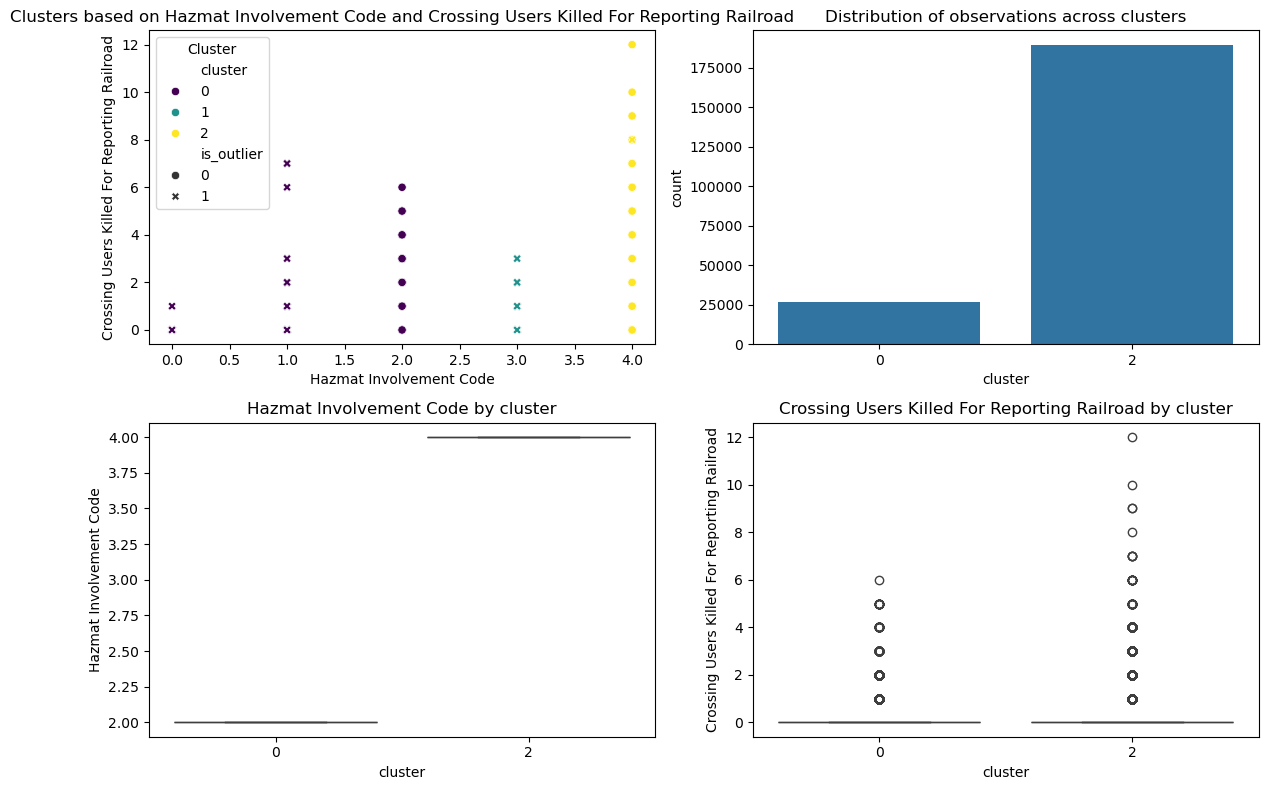


Cluster centers (mean values - after one-hot encoding):
         Crossing Users Killed For Reporting Railroad  \
cluster                                                 
0                                            0.139418   
2                                            0.096994   

         Crossing Users Injured For Reporting Railroad  \
cluster                                                  
0                                             0.407436   
2                                             0.332020   

         Employees Killed For Reporting Railroad  \
cluster                                            
0                                       0.000389   
2                                       0.000390   

         Employees Injured For Reporting Railroad  \
cluster                                             
0                                        0.026286   
2                                        0.021898   

         Passengers Killed For Reporting Railroad  \
cluste

In [18]:
# Visualizando os pesos das features (agora incluindo as features codificadas)
feature_importance = pd.DataFrame({
  'Feature': X.columns,
  'Weight': rskc_result['weights']
})
feature_importance = feature_importance.sort_values('Weight', ascending=False)

print("Feature importance for clustering (after one-hot encoding):")
print(feature_importance)

# Visualização dos clusters (usando as features codificadas)
plt.figure(figsize=(12, 8))

# Escolhendo as duas features mais importantes para visualização
top_features_encoded = feature_importance['Feature'].iloc[:2].tolist()
if len(top_features_encoded) >= 2:
    plt.subplot(2, 2, 1)
    sns.scatterplot(
        x=dataset_encoded[top_features_encoded[0]],
        y=dataset_encoded[top_features_encoded[1]],
        hue=dataset_encoded['cluster'],
        style=dataset_encoded['is_outlier'],
        palette='viridis'
    )
    plt.title(f'Clusters based on {top_features_encoded[0]} and {top_features_encoded[1]}')
    plt.legend(title='Cluster')

# Visualizando a distribuição de cada cluster
plt.subplot(2, 2, 2)
dataset_without_outliers_encoded = dataset_encoded[dataset_encoded['is_outlier'] == 0]
sns.countplot(x='cluster', data=dataset_without_outliers_encoded)
plt.title('Distribution of observations across clusters')

# Análise de características por cluster (usando as features codificadas)
# Vamos mostrar boxplots para algumas das features codificadas mais importantes
plt.subplot(2, 2, 3)
for i, feature in enumerate(top_features_encoded[:3]):  # Primeiras 3 features mais importantes
    plt.subplot(2, 2, 3 + i)
    sns.boxplot(x='cluster', y=feature, data=dataset_without_outliers_encoded)
    plt.title(f'{feature} by cluster')

plt.tight_layout()
plt.show()

# Estatísticas descritivas por cluster (usando as features codificadas)
cluster_stats_encoded = dataset_without_outliers_encoded.groupby('cluster')[features_encoded].mean()
print("\nCluster centers (mean values - after one-hot encoding):")
print(cluster_stats_encoded)

# Análise de outliers
if len(outliers) > 0:
    print("\nOutlier analysis:")
    outlier_data_encoded = dataset_encoded[dataset_encoded['is_outlier'] == 1]
    print(f"Number of outliers: {len(outlier_data_encoded)}")
    print("Summary statistics for outliers (after one-hot encoding):")
    print(outlier_data_encoded[features_encoded].describe())

### Applying xAI

In [ ]:
## incluir interpretação via SHAP e Lime

## Adaptively Robust and Sparse K-Means


In [ ]:
# Aplicação do algoritmo RSKOD
# Parâmetros:
# k: número de clusters (ex: 3)
# c: parâmetro de penalização para seleção de features (ex: 0.1)
# lambda_val: parâmetro para robustez a outliers (ex: 0.5)
# w: pesos iniciais para as features (inicializados uniformemente)

# Inicialização dos pesos (iguais para todas as features)
n_features = X_scaled.shape[1]
initial_weights = np.ones(n_features) / np.sqrt(n_features)

# Número de clusters desejado
k = 3  # ajuste conforme necessário

# Parâmetros de regularização
c = 0.1  # controla a esparsidade (features selecionadas)
lambda_val = 0.5  # controla a robustez a outliers

# Executar o algoritmo
resultado = RSKOD(k=k, c=c, lambda_val=lambda_val, dataset=X_scaled, w=initial_weights)

# Acessar os resultados
pesos_features = resultado['w_f']
clusters = resultado['spare_okm_cluster']
outliers = resultado['spare_okm_outlier_idx']

# Analisar quais features foram selecionadas (pesos não próximos de zero)
feature_importance = dict(zip(features, pesos_features))
selected_features = [f for f, w in feature_importance.items() if abs(w) > 0.01]

print("Features selecionadas:", selected_features)
print("Importância das features:", feature_importance)
print("Número de outliers detectados:", len(outliers))

# Adicionar os resultados do clustering ao dataframe original
dataset['cluster'] = clusters
dataset['is_outlier'] = 0
dataset.loc[outliers, 'is_outlier'] = 1

# Visualizar os resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Selecionar as duas features mais importantes para visualização
top_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:2]
feature_x, feature_y = top_features[0][0], top_features[1][0]

# Plotar os clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=dataset, x=feature_x, y=feature_y, hue='cluster', style='is_outlier',
                palette='viridis', s=100, alpha=0.7)
plt.title('Clustering com RSKOD')
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()